In [1]:
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym

import gym_env
from utils import decision_policy, woodbury, woodbury_SR, decision_policy_SR
from utils_render import plot_decision_prob_detour
from models import SR_IS, SR_TD

In [ ]:
seeds = np.arange(70)

## Parameters
reward = -0.01
alpha = 0.1
beta = 1.0
_lambda = 1.0
num_steps = 120000
decay = False
decay_params = [0.99, 150]

# For plotting
prob_locs = [12, 4, 6]
colors = [3, 2, 4]

# Save dir
save_dir = os.path.join('..', 'figures/')

In [3]:
train_SR = []
test_SR = []
train_SR_IS = []
test_SR_IS = []

for seed in seeds:
    print(f"Seed: {seed}")
    # Define and train models
    SR_IS_agent = SR_IS(env_name="tolman-9x9-nb", reward=reward, term_reward=50, _lambda=_lambda, beta=beta, 
                           alpha=alpha, num_steps=num_steps, policy="softmax", imp_samp=True, 
                           decay=decay, decay_params=decay_params)
    SR_agent = SR_TD(env_name="tolman-9x9-nb", reward=1, term_reward=50, gamma=0.9, beta=beta, alpha=alpha, num_steps=num_steps, policy="softmax", diag=False)

    SR_IS_agent.learn(seed=int(seed))
    SR_agent.learn(seed=int(seed))
    T_pi = decision_policy_SR(agent=SR_agent)

    # Get training decision policy
    pii_SR_IS = decision_policy(SR_IS_agent, SR_IS_agent.Z)
    pii_SR = T_pi

    probs_train_SR_IS = pii_SR_IS[5][prob_locs]
    probs_train_SR_IS_n = probs_train_SR_IS / np.sum(probs_train_SR_IS)
    probs_train_SR = pii_SR[5][prob_locs]
    probs_train_SR_n = probs_train_SR / np.sum(probs_train_SR)

    # Append probs
    train_SR.append(probs_train_SR_n)
    train_SR_IS.append(probs_train_SR_IS_n)

    # Get new maze and initialize a new agent
    env_blocked = gym.make("tolman-9x9-b")
    maze_blocked = env_blocked.unwrapped.maze
    new_agent = SR_IS(env_name="tolman-9x9-nb", _lambda=_lambda, beta=beta, alpha=alpha)

    # Block transition to from state 15 -> state 18
    transition_state = 12 # 15
    blocked_state = 15 # 18

    # Make a new transition matrix that doesn't allow transition to blocked state
    T_new = np.copy(SR_IS_agent.T)

    # Set transitions to the blocked state to 0
    T_new[transition_state, blocked_state] = 0
    T_new[blocked_state, transition_state] = 0

    # Calculate the sum of transitions for each row, excluding transitions to the blocked state
    row_sums = np.sum(T_new, axis=1)

    # Normalize non-zero transitions
    non_zero_indices = np.where(row_sums != 0)
    T_new[non_zero_indices] /= row_sums[non_zero_indices][:, np.newaxis]

    # Update SR-IS with Woodbury
    D_new = woodbury(SR_IS_agent, T_new, inv=False)

    Z_values_with, V_values_with = np.zeros(new_agent.size), np.zeros(new_agent.size)
    Z_values_with[~SR_IS_agent.terminals] = D_new[~SR_IS_agent.terminals][:,~SR_IS_agent.terminals] @ SR_IS_agent.P @ np.array([np.exp(50)])
    Z_values_with[SR_IS_agent.terminals] = np.exp(50)

    np.where(Z_values_with == np.min(Z_values_with))
    Z_values_with += (np.abs(np.min(Z_values_with)) + 0.1)

    V_values_with = np.log(Z_values_with)

    new_agent.V = V_values_with
    new_agent.DR = D_new
    new_agent.P = T_new[~new_agent.terminals][:,new_agent.terminals]
    new_agent.Z = Z_values_with
    new_agent.V = V_values_with

    pii_SR_IS = decision_policy(new_agent, new_agent.Z)
    probs_test_SR_IS = pii_SR_IS[5][prob_locs]
    probs_test_SR_IS_n = probs_test_SR_IS / np.sum(probs_test_SR_IS)

    # Update SR with Woodbury
    SR_new = woodbury_SR(SR_agent, T_new, T_pi, inv=False)
    SR_agent.SR = SR_new
    SR_agent.update_V()

    pii_SR = decision_policy_SR(agent=SR_agent)
    probs_test_SR = pii_SR[5][prob_locs]
    probs_test_SR_n = probs_test_SR / np.sum(probs_test_SR)

    # Append probs
    test_SR.append(probs_test_SR_n)
    test_SR_IS.append(probs_test_SR_IS_n)

Seed: 0


/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_90980/3146199793.py:64: RuntimeWarning: divide by zero encountered in log
  V_values_with = np.log(Z_values_with)


Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6


/Users/abizzle/Research/SR-IS/src/utils.py:299: RuntimeWarning: divide by zero encountered in divide
  zg = expv_tiled / G
/Users/abizzle/Research/SR-IS/src/utils.py:299: RuntimeWarning: invalid value encountered in divide
  zg = expv_tiled / G
/Users/abizzle/Research/SR-IS/src/utils.py:300: RuntimeWarning: invalid value encountered in multiply
  pii = agent.T * zg


Seed: 7
Seed: 8
Seed: 9
Seed: 10
Seed: 11
Seed: 12
Seed: 13
Seed: 14
Seed: 15
Seed: 16
Seed: 17
Seed: 18
Seed: 19
Seed: 20
Seed: 21
Seed: 22
Seed: 23
Seed: 24
Seed: 25
Seed: 26
Seed: 27
Seed: 28
Seed: 29
Seed: 30
Seed: 31
Seed: 32
Seed: 33
Seed: 34
Seed: 35
Seed: 36
Seed: 37
Seed: 38
Seed: 39
Seed: 40
Seed: 41
Seed: 42
Seed: 43
Seed: 44
Seed: 45
Seed: 46
Seed: 47
Seed: 48
Seed: 49
Seed: 50
Seed: 51
Seed: 52
Seed: 53
Seed: 54
Seed: 55
Seed: 56
Seed: 57
Seed: 58
Seed: 59
Seed: 60
Seed: 61
Seed: 62
Seed: 63
Seed: 64
Seed: 65
Seed: 66
Seed: 67
Seed: 68
Seed: 69


## Plot Decision Probabilities

In [4]:
def plot_decision_prob_detour(probs_train, probs_test, colors, leg_loc=None, save_path=None, title=None):
    plt.rcParams['font.family'] = 'serif'
    color_palette = sns.color_palette("colorblind")
    color_list = []
    for color in colors:
        color_list.append(color_palette[color])
    
    # Convert lists of arrays to numpy arrays and calculate mean and std error
    probs_train_array = np.array(probs_train)  # Shape: (n_samples, n_states)
    probs_test_array = np.array(probs_test)    # Shape: (n_samples, n_states)
    
    # Calculate means across samples
    mean_train = np.mean(probs_train_array, axis=0)
    mean_test = np.mean(probs_test_array, axis=0)
    
    # Ensure means are arrays (handle single sample case)
    mean_train = np.atleast_1d(mean_train)
    mean_test = np.atleast_1d(mean_test)
    
    # Calculate standard error (std / sqrt(n))
    std_train = np.std(probs_train_array, axis=0, ddof=1)
    std_test = np.std(probs_test_array, axis=0, ddof=1)
    
    # Ensure stds are arrays and handle single sample case
    std_train = np.atleast_1d(std_train)
    std_test = np.atleast_1d(std_test)
    
    stderr_train = std_train / np.sqrt(len(probs_train))
    stderr_test = std_test / np.sqrt(len(probs_test))
    
    min_visible_height = 0.02
    mean_train_plot = mean_train.copy()
    mean_test_plot = mean_test.copy()
    mean_train_plot[mean_train_plot < 0.1] = min_visible_height
    mean_test_plot[mean_test_plot < 0.1] = min_visible_height

    bar_positions_training = np.arange(len(mean_train)) * 0.4
    bar_positions_test = np.arange(len(mean_train)) * 0.4 + 1.5

    plt.bar(bar_positions_training, mean_train_plot, width=0.3, color=color_list, edgecolor='black')
    plt.bar(bar_positions_test, mean_test_plot, width=0.3, color=color_list, edgecolor='black')

    # Add error bars using the original mean values (not the adjusted ones for visibility)
    plt.errorbar(bar_positions_training, mean_train_plot, yerr=stderr_train, 
                fmt='none', ecolor='black', capsize=0, capthick=1)
    plt.errorbar(bar_positions_test, mean_test_plot, yerr=stderr_test, 
                fmt='none', ecolor='black', capsize=0, capthick=1)

    handles = [plt.Rectangle((0,0),1,1, facecolor=color_list[i], edgecolor='black') for i in range(len(mean_train))]

    if leg_loc is not None:
        plt.legend(handles, [f'$\mathrm{{s}}_{i+1}$' for i in range(len(mean_train))], title='States', loc=leg_loc, fontsize=14)
    else:
        plt.legend(handles, [f'$\mathrm{{s}}_{i+1}$' for i in range(len(mean_train))], title='States', loc='upper right', fontsize=14)
    
    plt.ylabel('Probabilities', fontsize=18)
    plt.xticks([0.4, 1.9], ['Training', 'Test'], fontsize=18)

    # Set custom y-axis ticks
    max_prob = max(max(mean_train_plot), max(mean_test_plot))
    y_ticks = np.arange(0, max_prob + 0.1, 0.1)
    plt.yticks(y_ticks)

    if title is not None:
        plt.title(title, fontsize=20)

    # Save the image
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

### SR-IS

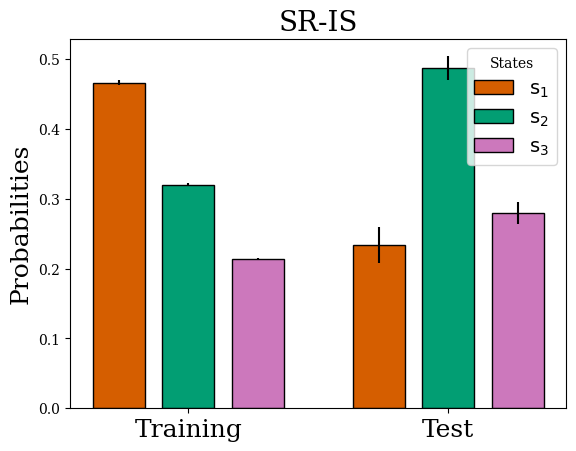

In [ ]:
save_path = save_dir + 'detour_SR-IS.png'
plot_decision_prob_detour(probs_train=train_SR_IS, probs_test=test_SR_IS, colors=colors, title='SR-IS', save_path=None)

### SR

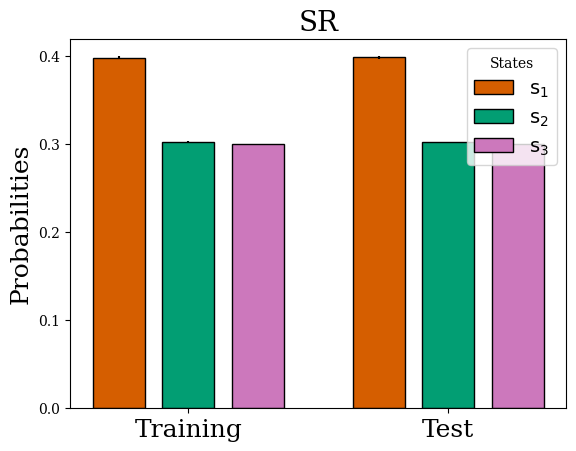

In [ ]:
save_path = save_dir + 'detour_SR.png'
plot_decision_prob_detour(probs_train=train_SR, probs_test=test_SR, colors=colors, title='SR', save_path=None)